In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.io.json import json_normalize

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pybedtools import BedTool

In [4]:
#To do:
#separate training from testing
#make sure the cv is stratified
#consider a random forest instead( test)

#idea: per case_id, create an average across starting_position, the chromosome one hots, and all base one hots

In [5]:
#parse data with json package
with open('out.json') as exampleData2:
    parsedData2 = json.load(exampleData2)

#create dictionary organized by observation (i.e., "hit")
hitsDictionary = parsedData2["data"]["hits"]

#normalize the data into a dataframe
df = pd.io.json.json_normalize(hitsDictionary)

#modify column headings
df.columns = df.columns.map(lambda x: x.split(".")[-1])

In [6]:
#Data Cleaning:

#under the assumption that only one distinct gene is cited in the "consequence" column,
#extract gene name and place in new column
def gene_extract(row):
    entry = row['consequence']
    entry_transform = entry[0]["transcript"]["gene"]["symbol"]
    return entry_transform

df['gene_symbol'] = df.apply (lambda row: gene_extract(row), axis=1)

In [7]:
#attribute creation:
#count the number of times that the gene was cited in the "consequence" column,
#in order to use it later as a measure of strength of gene expression (?)

def gene_count(row):
    entry = row['consequence']
    entry_transform = len(entry)
    return entry_transform

df['gene_citations'] = df.apply (lambda row: gene_count(row), axis=1)

In [8]:
#delete the consequence column - no additional information here
del df['consequence']

In [9]:
#I can see that there is only one distinct mutation type and mutation subtype:
#therefore delete those two columns:

del df['mutation_type']
del df['mutation_subtype']

In [10]:
#SANITY CHECKS:

#check for repeats in "id" column
df_count = df['id'].nunique()
print("No repeat IDs?:", df_count == df.shape[0])
df_count2 = df['primary_site'].nunique()
print("Number of primary cancer sites:", df_count2)
df_count3 = df['case_id'].nunique()
print("Number of cases:", df_count3)
df_count4 = df['project_id'].nunique()
print("Number of projects:", df_count4)
df_count5 = df["chromosome"].nunique()
print("Number of chromosomes:", df_count5)
df_count6 = df["gene_symbol"].nunique()
print("Number of genes:", df_count6)
df_count7 = df["start_position"].nunique()
print("Number of start positions:", df_count7)

No repeat IDs?: True
Number of primary cancer sites: 26
Number of cases: 9097
Number of projects: 33
Number of chromosomes: 24
Number of genes: 18177
Number of start positions: 159995


In [11]:
#delete id because meaningless
del df['id']

#end position never differs from start position (checked), therefore can delete one
del df['end_position']

In [12]:
#Tested that the chromosome in genomic_dna_change always equals the given chromosome.

#need to parse genomic_dna_change
#Here I remove bases

df['bases'] = df['genomic_dna_change'].str.slice(start=-3, stop=None, step=None)

#Here I identify the base changes
df['bases_first'] = df['bases'].str.slice(start=0, stop=1, step=None)
df['bases_second'] = df['bases'].str.slice(start=2, stop=3, step=None)

#note that the project_id is probably a label and relates to the primary_site label - cannot use as feature

del df['project_id']

In [13]:
#features: chromosome, start_position, gene_symbol, gene_citations, bases, genomic_dna_change
one_hot_chromosome = pd.get_dummies(df[['chromosome']], drop_first=True)
one_hot_bases = pd.get_dummies(df[['bases', 'bases_first', 'bases_second']], drop_first=True)  
data = pd.concat([df[[ 'start_position', 'gene_citations']], one_hot_chromosome, one_hot_bases], axis=1)

target = np.ravel(np.array(df[['primary_site']]))

In [17]:
#Load the BEDfile and make sense of it
genes = BedTool('gencode.v22.annotation.bed.gz')
genes = genes.sort()

bedfile = df.loc[:,('chromosome','start_position', 'start_position')]
bedfile = BedTool(np.ndarray.tolist(np.array(bedfile)))
bedfile = bedfile.sort()

In [18]:
def hack1(x):
    if (x == 'X'):
        return 50
    else:
        if (x=='Y'):
            return 51
        else:
            return x

In [19]:
#this will function as a lookup table
empty = np.zeros((214819, 4))
count=0

for nearest in BedTool(bedfile).closest(genes):
    #print(nearest[1]) #[4:5]
    empty[count,0] = hack1(nearest[0][3:])
    empty[count,1] = nearest[1]
    empty[count,2] = hack1(nearest[3][3:])
    empty[count,3] = nearest[4]
    count += 1

In [20]:
empty = empty.astype(int) #this mpas to 21,000 start points... Are they meaningful without chromosome number?
#the range of the startpoint looks like it's distinct per chromosome, so yes

In [21]:
keys1 = empty[:,0]
keys2 = empty[:,1]
values = empty[:,3]
mydict = dict(zip( zip(keys1.astype(int), keys2.astype(int)), values.astype(int)))



In [23]:
#test = np.ndarray.tolist(np.array(test))
#test = BedTool(test)
#print(test)

In [24]:
#for nearest in BedTool(bedfile).closest(genes):
 #   print(nearest)

    

In [25]:
#in df: chromosome, start_position
#make a new chromosome col to conform with the np array
#strip chr from new chrom col
df['new_chr'] = df['chromosome'].str.slice(3,)
df['new_chr'] = df['new_chr'] .apply (hack1)



#make a dictionary out of the lookup table
#want to add to 'df' dataframe: 'closest_gene' for each of 182,000 lines


empty_list = []

tuples = zip(np.array(df['new_chr']).astype(int), np.array(df['start_position']))
#x = np.array(df['new_chr']).astype(int)
#y = np.array(df['start_position'])

for x,y in tuples:
    empty_list.append( mydict[(x,y)] )

df['closest'] = empty_list


#then have to run it through the averaging thing againd


In [26]:
#aggregate the various mutations and associated genes for each case
#then determine whether the algorithm needs to be multiclass (one class per case) or multilabel (up to several)

#by case:

#initialize

data3 = pd.concat([df[[ 'case_id', 'primary_site', 'closest']], data], axis=1)

cases = pd.DataFrame(0, index=[0], columns=data3.columns[2:])

target = []

for n in df['case_id'].unique():
    new_case = pd.DataFrame(data3[data3['case_id']== n ])
    
    new_primary_site = np.array(new_case.primary_site)[0]
    target.append(new_primary_site)

    del new_case['case_id']
    del new_case['primary_site']

    new_mat = pd.DataFrame(new_case.mean(axis=0)).T #average across the one-hots, or median across the one-hots
    cases = cases.append(new_mat)

cases = cases.iloc[1:] 

In [28]:
counts = pd.DataFrame(index=pd.Series(target).unique(),columns=['count'])

for i in pd.Series(target).unique():
    counts.loc[i, 'count'] = np.sum(pd.Series(target) == i)
    
counts

,count
Uterus,573
Brain,789
Colorectal,535
Cervix,283
Soft Tissue,210
Liver,356
Prostate,383
Breast,910
Skin,458
Kidney,634


In [38]:
X_train.shape

(7277, 43)

In [37]:
#Now for the aggregated data;

#Split the data into training and test sets. 
#stratified sampling by iris class to ensure both the training and test sets contain a balanced 
#number of representatives of each of the three classes.

X_train, X_test, y_train, y_test = train_test_split(cases, target, test_size=0.2, stratify=target, random_state=0)


rf = RandomForestClassifier(n_estimators=100) #(n_estimators=100, oob_score=True, random_state=123456)

#need stratification here also:
cv = cross_val_score(rf, X_train, y_train, cv=10)
#Consider using StratifiedKFold to preserve original data balance
np.mean(cv)

#26.2 for aggregated w/o closest

0.2569714783724345

In [39]:
from sklearn.metrics import accuracy_score

rf_fit = rf.fit(X_train, y_train)

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
accuracy

0.26868131868131867

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=np.unique(target), index=np.unique(target))/np.sum(np.sum(cm), axis=0)

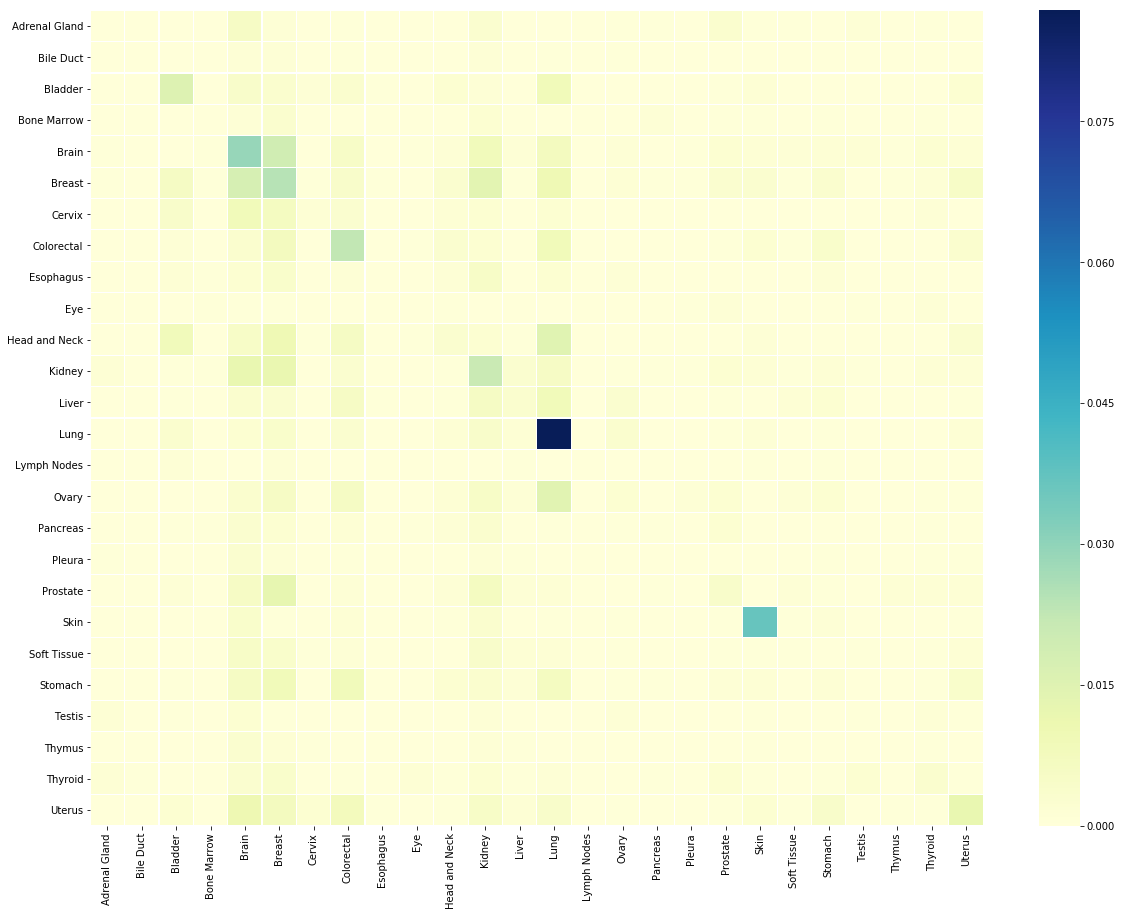

In [49]:
sns.heatmap(cm, linewidth=0.1, cmap="YlGnBu" )
plt.show()
plt.figure(figsize=(20,15))

#Presentation is in percent of entire test population: i.e., 8.6% of entire population was classifed correctly as Lung

In [42]:
#which features are most important
features = pd.DataFrame(rf_fit.feature_importances_, cases.columns)
features.columns = pd.Series('val')
features
features.sort_values(by='val', ascending=False)

,val
start_position,0.075310
closest,0.073148
gene_citations,0.070954
bases_C>T,0.036226
bases_G>A,0.035915
bases_C>A,0.033149
bases_G>T,0.032630
bases_second_T,0.031741
bases_first_G,0.030845
bases_first_C,0.030742


In [43]:
#a random classifier would have this accuracy:
1/26


0.038461538461538464